In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold

In [ ]:
# Variables globales
Imagenes = []
Etiquetas = []
IMG_TAM = 224  # Tamaño de las imágenes para MobileNet
DIR_BASE = '/content/drive/MyDrive/TT/Imagenes clasificadas'
DIR_ENFERMO_SR = DIR_BASE + '/Enfermo/Stem end Rot'
DIR_ENFERMO_BR = DIR_BASE + '/Enfermo/Body rot'
DIR_SANO = DIR_BASE + '/Sano'

#Data augmentation
DIR_ENFERMO_BR_brillo = DIR_BASE + '/Enfermo/Body rot/Augmented/brillo'
DIR_ENFERMO_BR_cs = DIR_BASE + '/Enfermo/Body rot/Augmented/channel_shift'
DIR_ENFERMO_BR_flip = DIR_BASE + '/Enfermo/Body rot/Augmented/flip_horizontal'
DIR_ENFERMO_BR_rotacion = DIR_BASE + '/Enfermo/Body rot/Augmented/rotacion'
DIR_ENFERMO_BR_zoom = DIR_BASE + '/Enfermo/Body rot/Augmented/zoom'

DIR_ENFERMO_SR_brillo = DIR_BASE + '/Enfermo/Stem end Rot/Augmented/brillo'
DIR_ENFERMO_SR_cs = DIR_BASE + '/Enfermo/Stem end Rot/Augmented/channel_shift'
DIR_ENFERMO_SR_flip = DIR_BASE + '/Enfermo/Stem end Rot/Augmented/flip_horizontal'
DIR_ENFERMO_SR_rotacion = DIR_BASE + '/Enfermo/Stem end Rot/Augmented/rotacion'
DIR_ENFERMO_SR_zoom = DIR_BASE + '/Enfermo/Stem end Rot/Augmented/zoom'

DIR_ENFERMO_SR_IA = DIR_BASE + '/Enfermo/Stem end Rot/AI generated'
#DIR_ENFERMO_BR_IA = DIR_BASE + '/Enfermo/Body rot/AI generated'




In [ ]:
# Función para obtener extensiones de archivos
def obtener_extension_archivos(DIR):
    ext = []
    for archivo in os.listdir(DIR):
        nom_archivo, ext_archivo = os.path.splitext(archivo)
        ext.append(ext_archivo)
    extensiones = set(ext)
    print(extensiones)

# Función para validar imágenes
def imagen_valida(archivo, extensiones=[".jpg", ".png", ".JPG", ".PNG", ".jfif", ".jpeg"]):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    es_archivo = os.path.isfile(archivo)
    es_imagen = ext_archivo.lower() in extensiones
    return es_archivo and es_imagen

# Función para construir la base de datos
def construir_base_datos(etiqueta, DIR):
    for archivo in tqdm(os.listdir(DIR)):
        ruta = os.path.join(DIR, archivo)
        if imagen_valida(ruta):
            img = tf.keras.preprocessing.image.load_img(ruta, color_mode='rgb')
            matriz_img = tf.keras.preprocessing.image.img_to_array(img)
            matriz_img = tf.image.resize(matriz_img / 255, [IMG_TAM, IMG_TAM])  # Cambiar tamaño a 224x224
            Imagenes.append(matriz_img.numpy())
            Etiquetas.append(etiqueta)

In [ ]:
# Obtener extensiones
obtener_extension_archivos(DIR_ENFERMO_SR)
obtener_extension_archivos(DIR_ENFERMO_BR)
obtener_extension_archivos(DIR_SANO)

{'', '.png', '.PNG', '.JPG', '.webp', '.jpeg', '.jpg', '.jfif'}
{'', '.png', '.JPG', '.PNG', '.jpeg', '.jpg', '.jfif'}
{'', '.avif', '.JPG', '.jpeg', '.jpg', '.jfif'}


In [ ]:
# Etiquetas de las clases
clases = ['Sano', 'Enfermo_BODYROT', 'Enfermo_STEMENDROT']
construir_base_datos(0, DIR_SANO)
construir_base_datos(1, DIR_ENFERMO_BR)
construir_base_datos(1, DIR_ENFERMO_BR_brillo)
construir_base_datos(1, DIR_ENFERMO_BR_cs)
construir_base_datos(1, DIR_ENFERMO_BR_flip)
construir_base_datos(1, DIR_ENFERMO_BR_rotacion)
construir_base_datos(1, DIR_ENFERMO_BR_zoom)
construir_base_datos(2, DIR_ENFERMO_SR)
construir_base_datos(2, DIR_ENFERMO_SR_brillo)
construir_base_datos(2, DIR_ENFERMO_SR_cs)
construir_base_datos(2, DIR_ENFERMO_SR_flip)
construir_base_datos(2, DIR_ENFERMO_SR_rotacion)
construir_base_datos(2, DIR_ENFERMO_SR_zoom)
construir_base_datos(2, DIR_ENFERMO_SR_IA)

# Codificar las etiquetas
codificadorEtiquetas = LabelEncoder()
claveEtiquetas = codificadorEtiquetas.fit_transform(Etiquetas)

# Convertir a one-hot
claveEtiquetas = tf.keras.utils.to_categorical(claveEtiquetas, num_classes=len(clases))

# Convertir las imágenes a un arreglo numpy
imagenes = np.array(Imagenes)
etiquetas = np.array(claveEtiquetas)


100%|██████████| 9/9 [00:03<00:00,  2.95it/s]


In [ ]:
# Convertir las etiquetas a un arreglo numpy
etiq = np.array(Etiquetas)

# Contar la cantidad de imágenes por clase
cantidad_sano = np.sum(etiq == 0)
cantidad_enfermo_bodyrot = np.sum(etiq == 1)
cantidad_enfermo_stemendrot = np.sum(etiq == 2)

# Imprimir las cantidades
print(f'Cantidad de imágenes en la clase "Sano": {cantidad_sano}')
print(f'Cantidad de imágenes en la clase "Enfermo_BODYROT": {cantidad_enfermo_bodyrot}')
print(f'Cantidad de imágenes en la clase "Enfermo_STEMENDROT": {cantidad_enfermo_stemendrot}')

Cantidad de imágenes en la clase "Sano": 165
Cantidad de imágenes en la clase "Enfermo_BODYROT": 312
Cantidad de imágenes en la clase "Enfermo_STEMENDROT": 405


In [ ]:
# Definir el número de folds
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Guardar resultados de cada fold
fold_accuracies = []
fold_conf_matrices = []

for fold, (train_idx, test_idx) in enumerate(kf.split(imagenes)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Dividir los datos en conjuntos de entrenamiento y prueba para este fold
    img_entrenamiento, img_prueba = imagenes[train_idx], imagenes[test_idx]
    etq_entrenamiento, etq_prueba = etiquetas[train_idx], etiquetas[test_idx]

    # Crear el modelo MobileNet
    from tensorflow.keras.applications import MobileNet

    modelo = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_TAM, IMG_TAM, 3))
    modelo.trainable = False  # Congelar las capas de MobileNet

    # Agregar capas adicionales
    x = tf.keras.layers.GlobalAveragePooling2D()(modelo.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    salida = tf.keras.layers.Dense(len(clases), activation='softmax')(x)  # 3 clases

    modelo = tf.keras.Model(inputs=modelo.input, outputs=salida)

    # Compilar el modelo usando categorical_crossentropy
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    historial = modelo.fit(img_entrenamiento, etq_entrenamiento,
                           validation_data=(img_prueba, etq_prueba),
                           epochs=10, batch_size=32, verbose=1)

    # Evaluar el modelo en el conjunto de prueba
    resultados = modelo.evaluate(img_prueba, etq_prueba, verbose=0)
    print(f"Precisión en Fold {fold + 1}: {resultados[1] * 100:.2f}%")
    fold_accuracies.append(resultados[1])

    # Generar predicciones
    predicciones = modelo.predict(img_prueba)
    predicciones_etq = np.argmax(predicciones, axis=1)

    # Obtener las etiquetas verdaderas
    etq_verdaderas = np.argmax(etq_prueba, axis=1)

    # Generar matriz de confusión
    conf_matrix = confusion_matrix(etq_verdaderas, predicciones_etq)
    fold_conf_matrices.append(conf_matrix)

Fold 1/5
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4923 - loss: 1.4548 - val_accuracy: 0.7853 - val_loss: 0.5051
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7925 - loss: 0.5464 - val_accuracy: 0.9096 - val_loss: 0.2833
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8876 - loss: 0.3101 - val_accuracy: 0.9266 - val_loss: 0.2212
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8856 - loss: 0.3145 - val_accuracy: 0.9492 - val_loss: 0.2145
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9153 - loss: 0.2211 - val_accuracy: 0.9661 - val_loss: 0.1657
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9390 - loss: 0.1729 - val_accuracy: 0.9605 - val_loss: 0.1504
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9621 - loss: 0.1345 - val_accuracy: 0.9661 - val_loss: 0.1423
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accura

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Fold 4/5
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4969 - loss: 1.1768 - val_accuracy: 0.8409 - val_loss: 0.4696
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8403 - loss: 0.4327 - val_accuracy: 0.8864 - val_loss: 0.3308
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8479 - loss: 0.3688 - val_accuracy: 0.9148 - val_loss: 0.2720
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9310 - loss: 0.2287 - val_accuracy: 0.9205 - val_loss: 0.2373
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9407 - loss: 0.1994 - val_accuracy: 0.9432 - val_loss: 0.1878
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9361 - loss: 0.1854 - val_accuracy: 0.9489 - val_loss: 0.1895
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9728 - loss: 0.1182 - val_accuracy: 0.9489 - val_loss: 0.1836
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9658 - l

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Fold 5/5
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5351 - loss: 1.1341 - val_accuracy: 0.8182 - val_loss: 0.4648
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8079 - loss: 0.4879 - val_accuracy: 0.9034 - val_loss: 0.3135
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8670 - loss: 0.3456 - val_accuracy: 0.8920 - val_loss: 0.2677
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9302 - loss: 0.2364 - val_accuracy: 0.9148 - val_loss: 0.2145
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9383 - loss: 0.2059 - val_accuracy: 0.9205 - val_loss: 0.2214
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9539 - loss: 0.1617 - val_accuracy: 0.9205 - val_loss: 0.1628
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9650 - loss: 0.1444 - val_accuracy: 0.9489 - val_loss: 0.1372
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9593 - l

In [ ]:
print(fold_accuracies)

[0.9717513918876648, 0.9435028433799744, 0.9602272510528564, 0.9602272510528564, 0.9545454382896423]


In [ ]:
# Imprimir precisión promedio
prec_media = np.mean(fold_accuracies)
print(f"Precisión promedio después de {k_folds} folds: {prec_media * 100:.2f}%")

Precisión promedio después de 5 folds: 95.81%


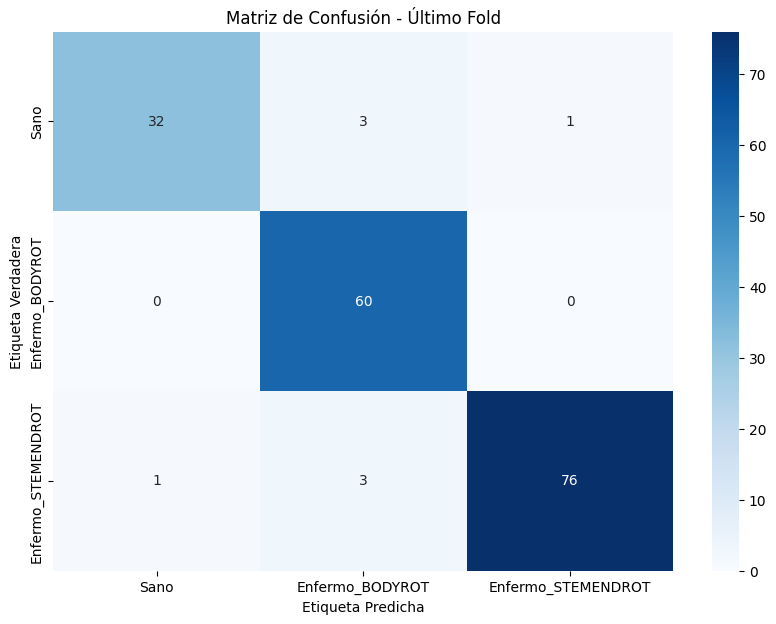

In [ ]:
# Visualizar la matriz de confusión del último fold
plt.figure(figsize=(10, 7))
sns.heatmap(fold_conf_matrices[-1], annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión - Último Fold')
plt.show()

{'.png', '.jpeg', '.PNG', '.webp', '.jpg', '.jfif', '.JPG'}
{'.jpeg', '.PNG', '.jpg', '.jfif', '.JPG'}
{'', '.jpeg', '.jpg', '.avif', '.jfif', '.JPG'}


100%|██████████| 126/126 [00:39<00:00,  3.18it/s]



 101


100%|██████████| 34/34 [00:20<00:00,  1.64it/s]



 135


100%|██████████| 68/68 [00:38<00:00,  1.74it/s]



 201
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4130 - loss: 1.4554 - val_accuracy: 0.6585 - val_loss: 0.7225
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.6433 - loss: 0.7809 - val_accuracy: 0.7561 - val_loss: 0.6351
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8270 - loss: 0.5279 - val_accuracy: 0.7561 - val_loss: 0.5853
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7901 - loss: 0.4457 - val_accuracy: 0.8049 - val_loss: 0.5392
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8516 - loss: 0.3930 - val_accuracy: 0.8049 - val_loss: 0.5823
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9100 - loss: 0.3269 - val_accuracy: 0.8293 - val_loss: 0.5159
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9264 - loss: 0.2311 - val_accuracy: 0.7805 - val_loss: 0.4766
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9060 - loss: 0.24

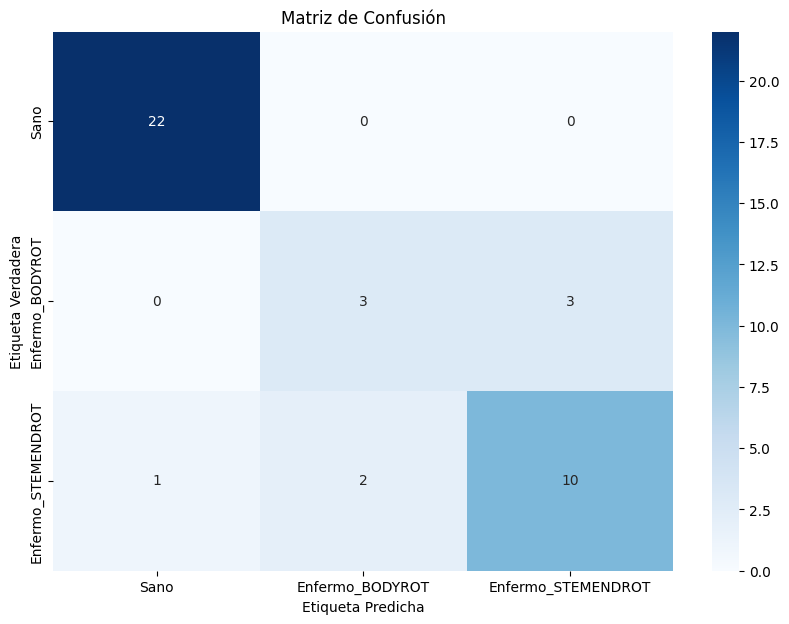

In [ ]:



# Función para obtener extensiones de archivos
def obtener_extension_archivos(DIR):
    ext = []
    for archivo in os.listdir(DIR):
        nom_archivo, ext_archivo = os.path.splitext(archivo)
        ext.append(ext_archivo)
    extensiones = set(ext)
    print(extensiones)

# Función para validar imágenes
def imagen_valida(archivo, extensiones=[".jpg", ".png", ".JPG", ".PNG", ".jfif", ".jpeg"]):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    es_archivo = os.path.isfile(archivo)
    es_imagen = ext_archivo.lower() in extensiones
    return es_archivo and es_imagen

# Obtener extensiones
obtener_extension_archivos(DIR_ENFERMO_SR)
obtener_extension_archivos(DIR_ENFERMO_BR)
obtener_extension_archivos(DIR_SANO)

# Función para construir la base de datos
def construir_base_datos(etiqueta, DIR):
    for archivo in tqdm(os.listdir(DIR)):
        ruta = os.path.join(DIR, archivo)
        if imagen_valida(ruta):
            img = tf.keras.preprocessing.image.load_img(ruta, color_mode='rgb')
            matriz_img = tf.keras.preprocessing.image.img_to_array(img)
            matriz_img = tf.image.resize(matriz_img / 255, [IMG_TAM, IMG_TAM])  # Cambiar tamaño a 224x224
            Imagenes.append(matriz_img.numpy())
            Etiquetas.append(etiqueta)

# Etiquetas de las clases
clases = ['Sano', 'Enfermo_BODYROT', 'Enfermo_STEMENDROT']
construir_base_datos(0, DIR_SANO)
print('\n', len(Etiquetas))
construir_base_datos(1, DIR_ENFERMO_BR)
print('\n', len(Etiquetas))
construir_base_datos(2, DIR_ENFERMO_SR)
print('\n', len(Etiquetas))

# Codificar las etiquetas
codificadorEtiquetas = LabelEncoder()
claveEtiquetas = codificadorEtiquetas.fit_transform(Etiquetas)

# Convertir a one-hot
claveEtiquetas = tf.keras.utils.to_categorical(claveEtiquetas, num_classes=len(clases))

# Dividir los datos en conjuntos de entrenamiento y prueba
img_entrenamiento, img_prueba, etq_entrenamiento, etq_prueba = train_test_split(
    Imagenes, claveEtiquetas, test_size=0.2, random_state=42)

# Convertir las imágenes a un arreglo numpy
img_entrenamiento = np.array(img_entrenamiento)
img_prueba = np.array(img_prueba)

# Crear el modelo MobileNet
from tensorflow.keras.applications import MobileNet

modelo = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_TAM, IMG_TAM, 3))
modelo.trainable = False  # Congelar las capas de MobileNet

# Agregar capas adicionales
x = tf.keras.layers.GlobalAveragePooling2D()(modelo.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
salida = tf.keras.layers.Dense(len(clases), activation='softmax')(x)  # 3 clases

modelo = tf.keras.Model(inputs=modelo.input, outputs=salida)

# Compilar el modelo usando categorical_crossentropy
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
historial = modelo.fit(img_entrenamiento, etq_entrenamiento,
                        validation_data=(img_prueba, etq_prueba),
                        epochs=10, batch_size=32)

# Generar predicciones
predicciones = modelo.predict(img_prueba)
predicciones_etq = np.argmax(predicciones, axis=1)

# Obtener las etiquetas verdaderas
etq_verdaderas = np.argmax(etq_prueba, axis=1)  # Convertir de one-hot a etiquetas enteras

# Generar matriz de confusión
conf_matrix = confusion_matrix(etq_verdaderas, predicciones_etq)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión')
plt.show()


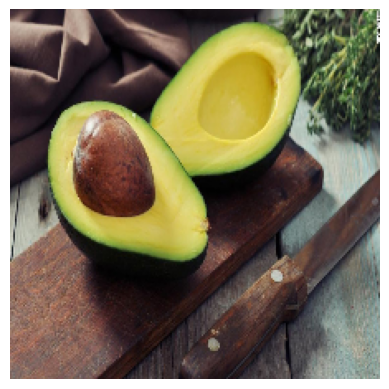

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
La imagen pertenece a la clase: Sano


In [ ]:

# Definir las clases que estás utilizando
clases = ['Sano', 'Enfermo_BODYROT', 'Enfermo_STEMENDROT']

# Función para predecir una imagen
def predecir_imagen(ruta_imagen, modelo, clases, img_tam=224):
    # Cargar la imagen
    img = tf.keras.preprocessing.image.load_img(ruta_imagen, target_size=(img_tam, img_tam))

    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convertir la imagen a un array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Redimensionar y normalizar la imagen
    img_array = np.expand_dims(img_array / 255.0, axis=0)  # Expandir la dimensión para que sea compatible con el modelo

    # Hacer la predicción
    prediccion = modelo.predict(img_array)

    # Obtener la clase predicha
    clase_predicha = np.argmax(prediccion, axis=1)[0]

    # Mostrar el resultado
    print(f"La imagen pertenece a la clase: {clases[clase_predicha]}")

# Ejemplo de uso
ruta_imagen = 'aguacateprueba.jpg'  # Cambiar a la ruta de tu imagen
predecir_imagen(ruta_imagen, modelo, clases)
